In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import random

# Data604 Final Project
Leo Yi

## Bagel Shop Morning Rush, Discrete Event Simulation

Sometimes I think about what life would be like if I quit my corporate office job and open up a bagel shop. Realistically, it would be a far journey to get to that point, but I want to create a simulation in order to understand how to effectively manage the morning rush of a successful fast service restaurant.

The overall goal is to produce enough bagels at regular intervals to provide a fresh product while also having enough employees to turn around all the orders without having a massive delay in the line.

I'll proceed with the following assumptions:
- People want bagels in the morning for breakfast, so we'll assume the simulation will last 4 hours from 7am - 11am.
- I think a single line queue is a fair way to handle customers, so we'll be operating on a first in, first out basis.
- We don't know how busy we might end up being, so for now, we'll assume we have unlimited bagels and then use the results of the simulation to estimate how big our oven should be.
  - Bagels take about 25 minutes to bake but also need more time for shaping and boiling each batch, so assume we can finish each bulk bake once per hour.
- The staff would be split between 2 groups:
  - The front - the employees who take your bagel order and prepare it accordingly
  - The bakers - the employees who shape and bake the bagels    
- The customers can ask for limited services:
  - Bagels from one to a dozen
  - Bagels 
    - Toasted or not
    - With or without spreads
  - Coffee

State of the system:
- Number of customers in queue (q)
- Number of orders being prepped (p)
- Number of bagels sold (b)
  
Events that change the system:
- Arrival (q+)
- Start Order (q-, p+)
- Finish Order (p-, b+)
  
Attributes of the system:
- entry_rate - this is the probability a customer enters each minute
- completion_time - this is the average number of minutes it takes to complete an order
- front_workers - this is the number of employees fulfilling orders

In [2]:
# create system
def make_system(entry_rate, completion_time, front_workers):
    t_0 = 0
    t_end = (11 - 7) * 60 # (end hour - start hour) * 60 minutes = total minutes

    completion_rate = (1 / completion_time)

    init = State(q = 0, p = 0, b = 0)

    system = System(init = init,
                    t_0 = t_0,
                    t_end = t_end,
                    entry_rate = entry_rate,
                    completion_rate = completion_rate,
                    front_workers = front_workers
                    )

    return system                    

In [3]:
# define updating function
def update_func(state, t, system):
    q, p, b = state

    # Finish Order event
    # determine if each occupied worker completed an order
    for i in (range(p)):
        if flip(system.completion_rate):            
            p -= 1
            b += random.randint(0,12) # assume there's a random chance at an order having between 1-12 bagels

    # Arrival event
    # determine if a new person was added to the line, max of 1 per minute
    if flip(system.entry_rate):
        q += 1

    # Start Order event
    # Orders being prepped, max orders limited to number of workers
    # if there is an available worker, have them start the order
    if q > 0 and p < system.front_workers:
        waiting = []
        waiting.append(system.front_workers - p) # available workers
        waiting.append(q) # people on line
        available_orders = min(waiting) # start as many orders as possible
        q -= int(available_orders)
        p += int(available_orders)
        
    
    
    return State(q=q, p=p, b=b)

In [4]:
# run simulation
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t_0] = system.init
    
    for t in linrange(system.t_0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [5]:
# get total bagels
def calc_total_bagels(results):
    return get_last_value(results.b)

def calc_oven_capacity(results):
    hours = (system.t_end - system.t_0) / 60
    return get_last_value(results.b) / hours

def print_bagel_summary(results):
    return print('Total Bagels Sold: ', calc_total_bagels(results), '\nEstimated Oven Capacity: ', calc_oven_capacity(results))
        

In [6]:
# setup plot functions
def plot_results(frame):    
    plot(frame.q, label='People in Queue')
    plot(frame.p, label='Processing Orders')    
    decorate(xlabel='Time (minutes)',
             ylabel='Number of People')

def plot_bagels(frame):
    plot(frame.b, label = 'Cumulative Bagels Sold')
    decorate(xlabel='Time (minutes)',
             ylabel='Number of Bagels')

## Run Simulations

Below, we'll run simulations using different parameters, plot the results, and explain what we're seeing.

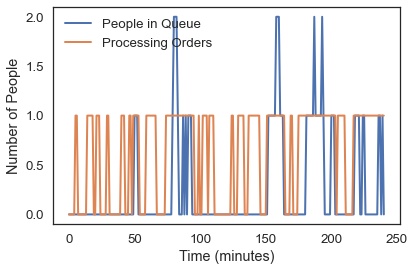

In [7]:
# One customer about every 5 minutes
# Order completed about every 3 minutes
# One worker
random.seed(99)
system = make_system(entry_rate = 0.2, completion_time = 3, front_workers = 1)
frame = run_simulation(system, update_func)

plot_results(frame)

In this case, a worker can complete an entire order before another customer is likely to arrive. We can see that the max number of waiting customers reached 2 people in line, which doesn't seem unreasonable. This means if you're the last person in line, you may have to wait about 10 minutes to get your order out the door.

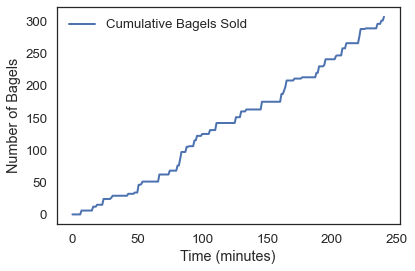

In [8]:
plot_bagels(frame)

In [9]:
print('Total Bagels Sold: ', calc_total_bagels(frame), '\nEstimated Oven Capacity: ', calc_oven_capacity(frame))

Total Bagels Sold:  307 
Estimated Oven Capacity:  76.75


Using a random uniform distribution, or random selection between 1 and 12 bagels, we're seeing 300 bagels sold per day using this simulation, or about 77 per hour. Assuming we can have fresh bagels hourly, we would want an oven with a capacity of just about 77 bagels.

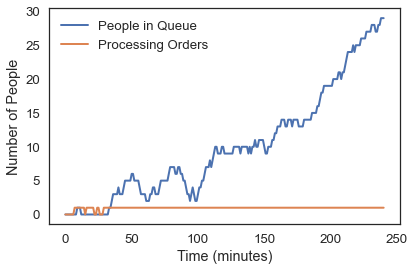

In [10]:
# One customer about every 3 minutes
entry_minute_interval = 3

# Order completed about every 5 minutes
completion_interval = 5

# Number of workers
workers = 1

random.seed(99)
system = make_system(entry_rate = 1 / entry_minute_interval, completion_time = completion_interval, front_workers = workers)
frame = run_simulation(system, update_func)

plot_results(frame)

This uncovers a flaw in the simulation -- we're missing the reality that if people wait in line too long, they'll eventually just leave and go somewhere else. Ultimately, we're using this simulation to optimize the situation, so it's not immediately useful at this moment. If we wanted to calculate the loss of sales, then we might go back and add this in.

This really demonstrates what happens if you're understaffed. In the first simulation, the orange line had many points where it was at zero -- meaning the employee was underutilized. In this situation, the employee was constantly working and the line still piled up.

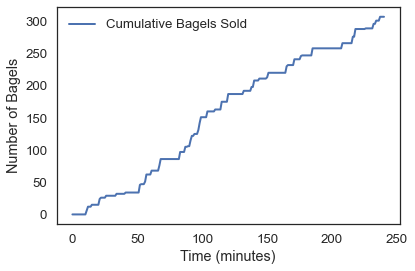

In [11]:
plot_bagels(frame)

In [12]:
print_bagel_summary(frame)

Total Bagels Sold:  307 
Estimated Oven Capacity:  76.75


This amount of bagels is actuall lower despite increased demand. The total bagels sold is capped due to the limitiations of supply due to the number of workers. 

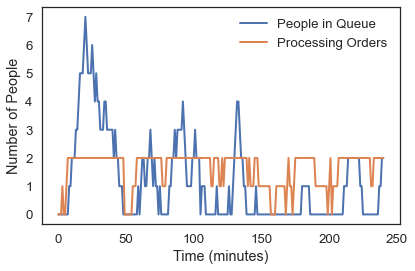

In [13]:
# One customer about every 3 minutes
entry_minute_interval = 3

# Order completed about every 5 minutes
completion_interval = 5

# Number of workers
workers = 2

random.seed(99)
system = make_system(entry_rate = 1 / entry_minute_interval, completion_time = completion_interval, front_workers = workers)
frame = run_simulation(system, update_func)

plot_results(frame)

This simulation was the same demand level as the last, except with one additional worker. The highest number of people on line only gets to 7 (vs 30 earlier), and this might seem reasonable. This is actually about 21 minutes of waiting, which isn't so great. The next decision would be to add another staff member to ensure some customers don't wait so long, but we need to consider the tradeoffs in cost between the brand and the cost of additional labor, which we don't do here for now.

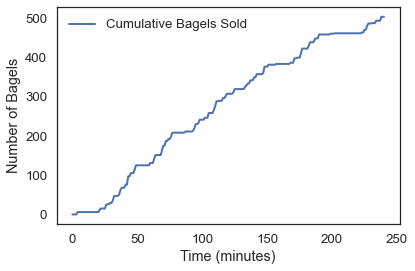

In [14]:
plot_bagels(frame)

In [15]:
print_bagel_summary(frame)

Total Bagels Sold:  503 
Estimated Oven Capacity:  125.75


With the current parameters, we're seeing about 500 bagels sold per day and 126 per hour. Depending on the scale of the business, the oven size would vary.

## Optimization

What if we knew how long it took on average to turn over an order and how often people are coming through the door? What we want to do at that point is to optimize the number of workers so that no one person is waiting too long.

Let's optimize based on the max number of people on line at any given time.

In [16]:
# function to calculate max number of people waiting in line at any time during the day
def calc_max_queue(results):
    return results.q.max()

# create a sweep series of max number of people waiting for every number of employees working
def sweep_workers(worker_array):
    sweep = SweepSeries()

    for w in worker_array:
        system = make_system(entry_rate = 1 / entry_minute_interval, completion_time = completion_interval, front_workers = w)
        frame = run_simulation(system, update_func)
        sweep[w] = calc_max_queue(frame)
    
    return sweep

In [17]:
# One customer about every minute
entry_minute_interval = 1

# Order completed about every 3 minutes
completion_interval = 3

# Number of workers, 1 - 10
workers = linspace(1, 10, 10)

random.seed(99)

max_line_sweep = sweep_workers(workers)

,values
1,162
2,82
3,14
4,3
5,0
6,0
7,0
8,0
9,0
10,0


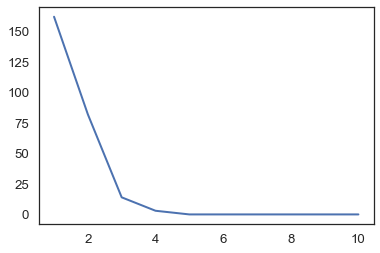

In [18]:
plot(max_line_sweep)

With 1 customer coming in every minute, and each order being filled every 3, it would be safe to assume that we only need 4 workers to handle most orders. Based on this simulation, we would see 14 people waiting at one point with 3 workers, 4 people waiting with 4 workers, and 0 people waiting with 5 or more workers. 

I'm curious to see the results using a different random seed:

In [19]:
random.seed(100)

max_line_sweep = sweep_workers(workers)

,values
1,153
2,81
3,29
4,3
5,1
6,0
7,0
8,0
9,0
10,0


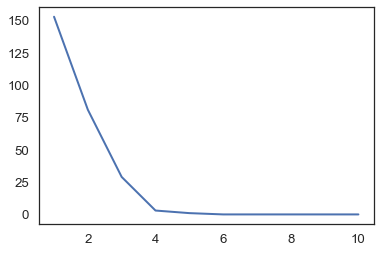

In [20]:
plot(max_line_sweep)

With a different random seed, we're seeing something similar from this simulation -- 29 max customers waiting with 3 workers, 3 customers waiting with 4 workers, and 1 customers waiting with 5 workers. 

## Conclusion

If it were up to me, I'd likely hire no fewer than 4 people if there was a customer coming in every minute or so, with order completion times about every 3 minutes. I would even consider 5 workers-- the additional labor cost is probably worth it if we can ensure that no single customer has to wait too long for their order.

Ultimately, it depends on what kind of demand we're seeing and also how long it takes to fulfill orders. We can also make the simulation more complicated if we have more real data. If we had actual historical sales data, we could adjust the probabilities for the number of bagels ordered and create better estimates for order time completion. Someone who orders a dozen bagels is likely to take them home whole, and it might be likely that most people only order one to four bagels. Also, egg bagels with bacon, sausage, and or cheese may take more time than cream cheese spreads.

A small business, or any business, requires iterative work in order to improve. We take what we know and adjust to make things more efficient. If we understand demand through accurate forecasts, we can also adjust how much dough we prepare the night before, as well as the optimal ingredents to order from vendors to maximize freshness and minimize waste. We can also use this information to create another simulation to optimize the work required and number of staff in the back of the kitchen.